# Task

### Pre-defined Code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')
from scipy import signal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

100%|██████████| 5/5 [00:00<00:00, 32.79it/s]


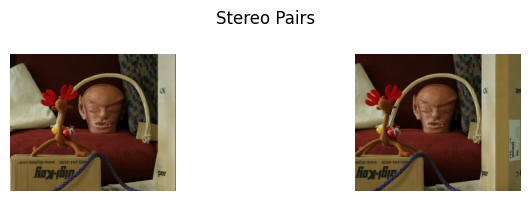

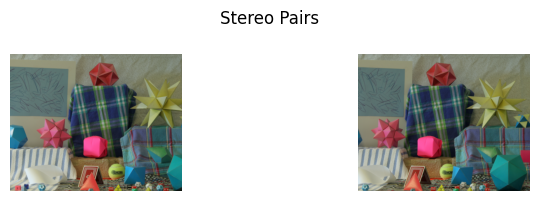

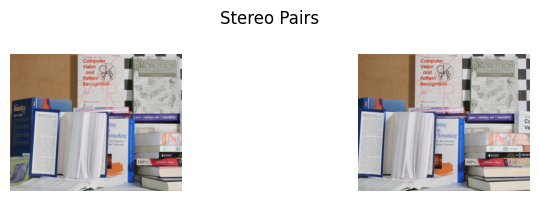

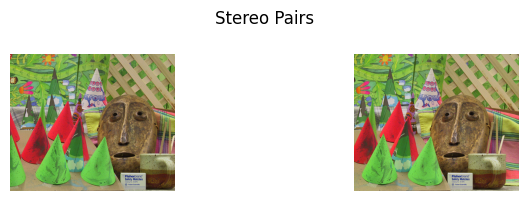

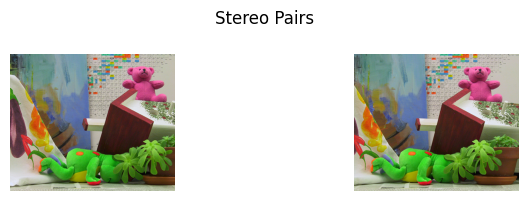

In [ ]:
# Loading all the images in the drive
pair_images = []

paths = natsorted(glob('/content/drive/My Drive/ES666CV/E/*'))

for idx in tqdm(range(0, len(paths), 2)):
    pair_images.append(np.array([cv2.imread(paths[idx], 1), cv2.imread(paths[idx+1], 1)]))

for pairs in pair_images:
    show_image_grid(pairs, 1, 2, 'Stereo Pairs', figsize=8)

### Reconstruction Algorithm

1. [Reconstruction](https://www.cs.cmu.edu/~16385/s15/lectures/Lecture19.pdf) [Must Read]

2. [Stereo and Disparity](https://johnwlambert.github.io/stereo/)

3. [Stereo and 3D Vision](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect16.pdf)

4. [Stereo Reconstruction](https://cs.nyu.edu/~fergus/teaching/vision/9_10_Stereo.pdf)

5. [Epipolar Geometry and the Fundamental Matrix](https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf)

### Q1: Matching Points [2 Marks]

Find the matching points between image pair. You can use OpenCV SIFT feature matching. Plot the matching points over the image.

ref: https://www.tutorialspoint.com/how-to-implement-flann-based-feature-matching-in-opencv-python


In [ ]:
def build_matching_point_pairs(image_a, image_b):
    matching_point_pair_lst = [] # [[image_a points], [image_b points]]
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image_a,None)
    kp2, des2 = sift.detectAndCompute(image_b,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])


    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

    matching_point_pair_lst = [src_pts, dst_pts]

    img3 = np.array(cv2.drawMatchesKnn(image_a,kp1,image_b,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
    #print(img3.shape)
    #print(image_a.shape)

    show_image_grid(np.array([image_a,image_b]),1,2,title='Images',figsize=8)
    lisst=np.array([img3])
    show_image_grid(lisst, 1, 1, title='Matching Points', figsize=8)

    return matching_point_pair_lst


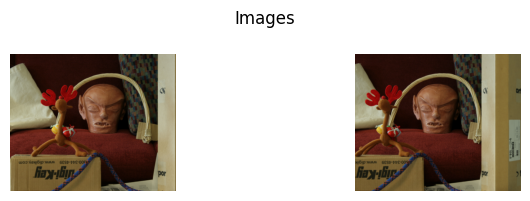

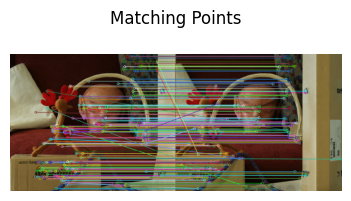

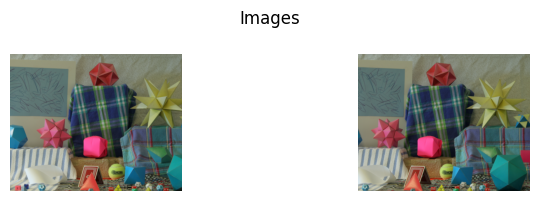

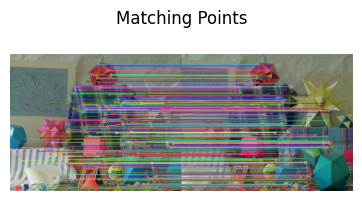

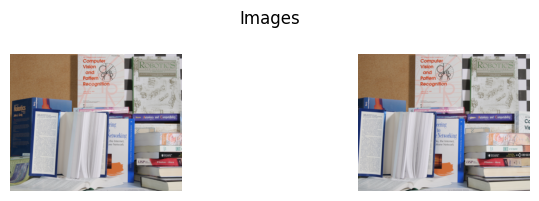

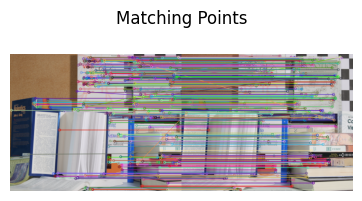

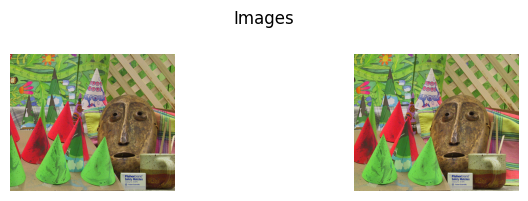

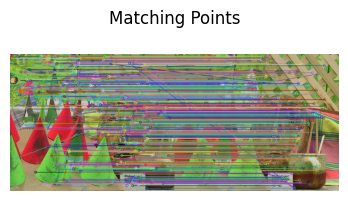

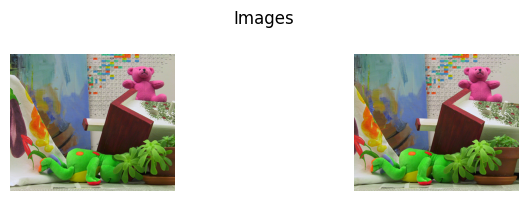

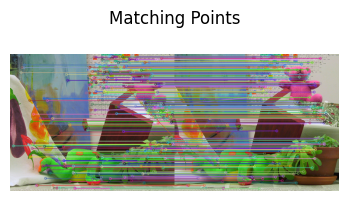

In [ ]:
global_matching_point_pair_lst = []

for pairs in pair_images:
    global_matching_point_pair_lst.append(build_matching_point_pairs(pairs[0], pairs[1]))

    # Plot the matching points here
    # show_image_grid(pairs, 1, 2, 'Stereo Pairs', figsize=8)

#print(global_matching_point_pair_lst)

### Q2: Estimate Camera Matrix [3 Marks]

Estimate the camera matrix [R | t] using matched points, for this question also you are allow to use OpenCV estimate Essential matrix and Camera matrix function.

impementation taken from: https://amroamroamro.github.io/mexopencv/matlab/cv.findEssentialMat.html

reference: https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html,
https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html#:~:text=We%20can%20use%20the%20function%2C%20cv.calibrateCamera()%20which%20returns,rotation%20and%20translation%20vectors%20etc.&text=Finds%20the%20camera%20intrinsic%20and,views%20of%20a%20calibration%20pattern.


In [ ]:
def estimate_camera_matrix(matching_point_a, matching_point_b):
    camera_matrix = None

    E, mask = cv2.findEssentialMat(matching_point_a, matching_point_b,method=cv2.RANSAC)
    points, R, t, mask = cv2.recoverPose(E, matching_point_a, matching_point_b, focal=1.0, pp=(0.,0))
    print(t.shape)
    camera_matrix = np.hstack((R, t))
    print(camera_matrix.shape)
    return camera_matrix

In [ ]:
global_camera_matrix_lst = []

for matching_point_pair in global_matching_point_pair_lst:
    camera_matrix=estimate_camera_matrix(matching_point_pair[0], matching_point_pair[1])
    global_camera_matrix_lst.append(camera_matrix)
    # image_a=cv2.warpPerspective(matching_point_pair[0].astype(np.uint8),camera_matrix,matching_point_pair[0].shape[:2])
    # show_image_grid(image_a,1,1,'title',figsize=16)

print(len(global_camera_matrix_lst))

(3, 1)
(3, 4)
(3, 1)
(3, 4)
(3, 1)
(3, 4)
(3, 1)
(3, 4)
(3, 1)
(3, 4)
5


### Q3: Stereo Rectification [2.5 Marks]

You have to perform stereo rectification based on the estimated camera matrix. This will help is algining the image pair which in turn help estimate disparity map easily.

Note: Implement it from scratch no use of OpenCV function is allowed for this part of the algorithm other than warping function if needed.

In [ ]:
def perform_stereo_rectification(image_a, image_b, matching_point_a, matching_point_b, camera_matrix):
    stereo_rectified_images = [] # [[image_a_rectified], [image_b_rectified]]


    return stereo_rectified_images

In [ ]:
def perform_stereo_rectification(image_a, image_b, camera_matrix):

    R=camera_matrix[:,:3]
    T=camera_matrix[:,3:]
    h, w = image_a.shape[:2]
    fx = fy = 1.0
    cx = w / 2.0
    cy = h / 2.0
    camera_matrix = np.array([[fx, 0, cx],
                               [0, fy, cy],
                               [0, 0, 1]], dtype=np.float64)

    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(camera_matrix, None,camera_matrix, None, (w, h),R, T,alpha=0.75)

    map1_a, map2_a = cv2.initUndistortRectifyMap(camera_matrix, None, R1, P1, (w, h), cv2.CV_32FC1)
    map1_b, map2_b = cv2.initUndistortRectifyMap(camera_matrix, None, R2, P2, (w, h), cv2.CV_32FC1)

    image_a_rectified = cv2.remap(image_a, map1_a, map2_a, interpolation=cv2.INTER_LINEAR)
    image_b_rectified = cv2.remap(image_b, map1_b, map2_b, interpolation=cv2.INTER_LINEAR)

    stereo_rectified_images = [image_a_rectified, image_b_rectified]
    return stereo_rectified_images

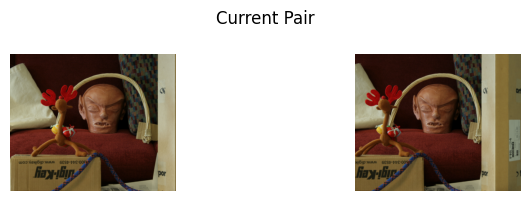

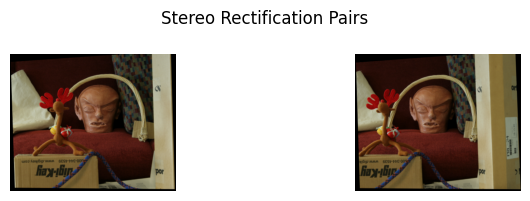

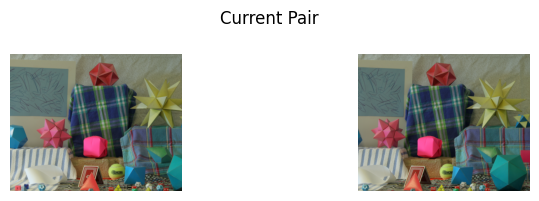

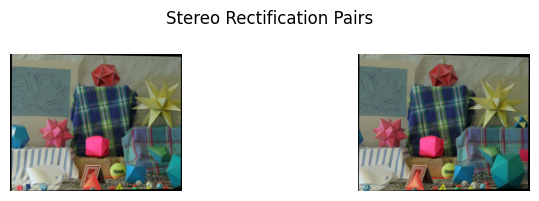

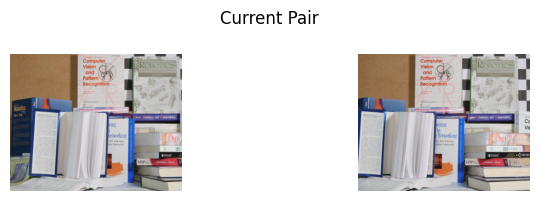

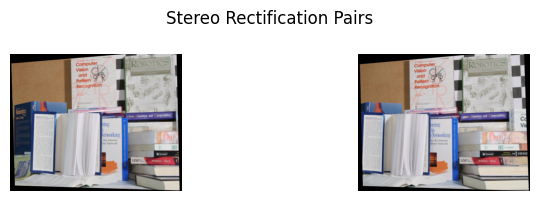

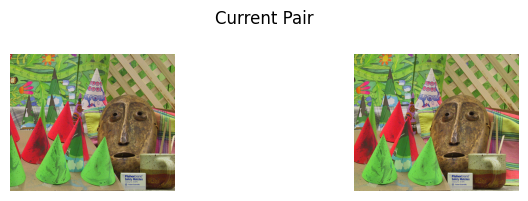

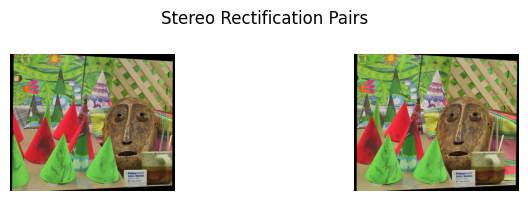

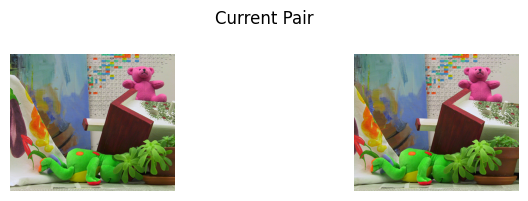

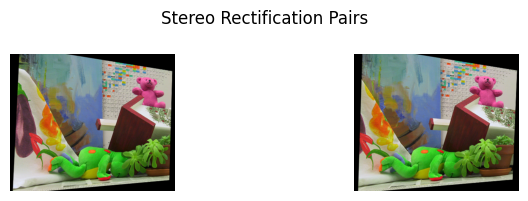

In [ ]:
N = len(pair_images)
rectified_pairs = []

for pair_idx in range(N):
    show_image_grid(pair_images[pair_idx],1,2,'Current Pair', figsize=8)
    algined_pairs = perform_stereo_rectification(pair_images[pair_idx][0], pair_images[pair_idx][1],global_camera_matrix_lst[pair_idx])

    rectified_pairs.append(np.array(algined_pairs))
    show_image_grid(rectified_pairs[-1], 1, 2, 'Stereo Rectification Pairs', figsize=8)

### Q4: Disparity Maps [2.5 Marks]

With the help of stereo rectification images, now have to obtain the disparity maps for each pair. No opencv functions are allowed for this algorithm. For convolution you can use scipy or opencv convolution.

In [ ]:
def disparity_map(image_a, image_b, block_size=8, max_disparity=64):

    image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
    image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

    h, w = image_a.shape

    half_block = block_size // 2

    disp_map = np.zeros((h, w), dtype=np.float32)

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):

            block_a = image_a[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            best_disparity = 0
            min_cost = float('inf')

            for d in range(min(max_disparity, x - half_block)):

                block_b = image_b[y - half_block:y + half_block + 1, x - half_block - d:x + half_block + 1 - d]

                cost = np.sum((block_a - block_b) ** 2)

                if cost < min_cost:
                    min_cost = cost
                    best_disparity = d

            disp_map[y, x] = best_disparity

    if max_disparity!=0:
      disp_map=(disp_map/max_disparity)*255

    return disp_map.astype(np.uint8)


In [ ]:
#k=np.array([[1,1,1],[1,1,1],[1,1,1]])

for pairs in rectified_pairs:
    disp_map = disparity_map(pairs[0], pairs[1])
    disp_map = cv2.applyColorMap(disp_map, cv2.COLORMAP_VIRIDIS) # disp_map is single channel image
    show_image_grid(np.array([pairs[0],pairs[1],disp_map]), 1, 3, 'Disparity Maps for Each Pair', figsize=16)
    #averaged= cv2.filter2D(src=disp_map, ddepth=-1, kernel=k)
    #plt.imshow(averaged,cmap='gray')

Output hidden; open in https://colab.research.google.com to view.